In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data inspection
Description of each column can be found [HERE](https://github.com/PrzemyslawLagosz/CV_proj/blob/main/ML_house_prediction/data/house_data_description.txt)

In [7]:
data = pd.read_csv("data/house_train.csv", index_col= [0])


In [8]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,Neighborhood,HouseStyle,...,GarageCars,PavedDrive,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,AllPub,CollgCr,2Story,...,2,Y,0,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,AllPub,Veenker,1Story,...,2,Y,0,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,AllPub,CollgCr,2Story,...,2,Y,0,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,AllPub,Crawfor,2Story,...,3,Y,0,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,AllPub,NoRidge,2Story,...,3,Y,0,NaN,0,12,2008,WD,Normal,250000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   HouseStyle     1460 non-null   object 
 10  OverallQual    1460 non-null   int64  
 11  OverallCond    1460 non-null   int64  
 12  YearBuilt      1460 non-null   int64  
 13  YearRemodAdd   1460 non-null   int64  
 14  ExterQual      1460 non-null   object 
 15  ExterCond      1460 non-null   object 
 16  Heating        1460 non-null   object 
 17  CentralAir     1460 non-null   object 
 18  1stFlrSF

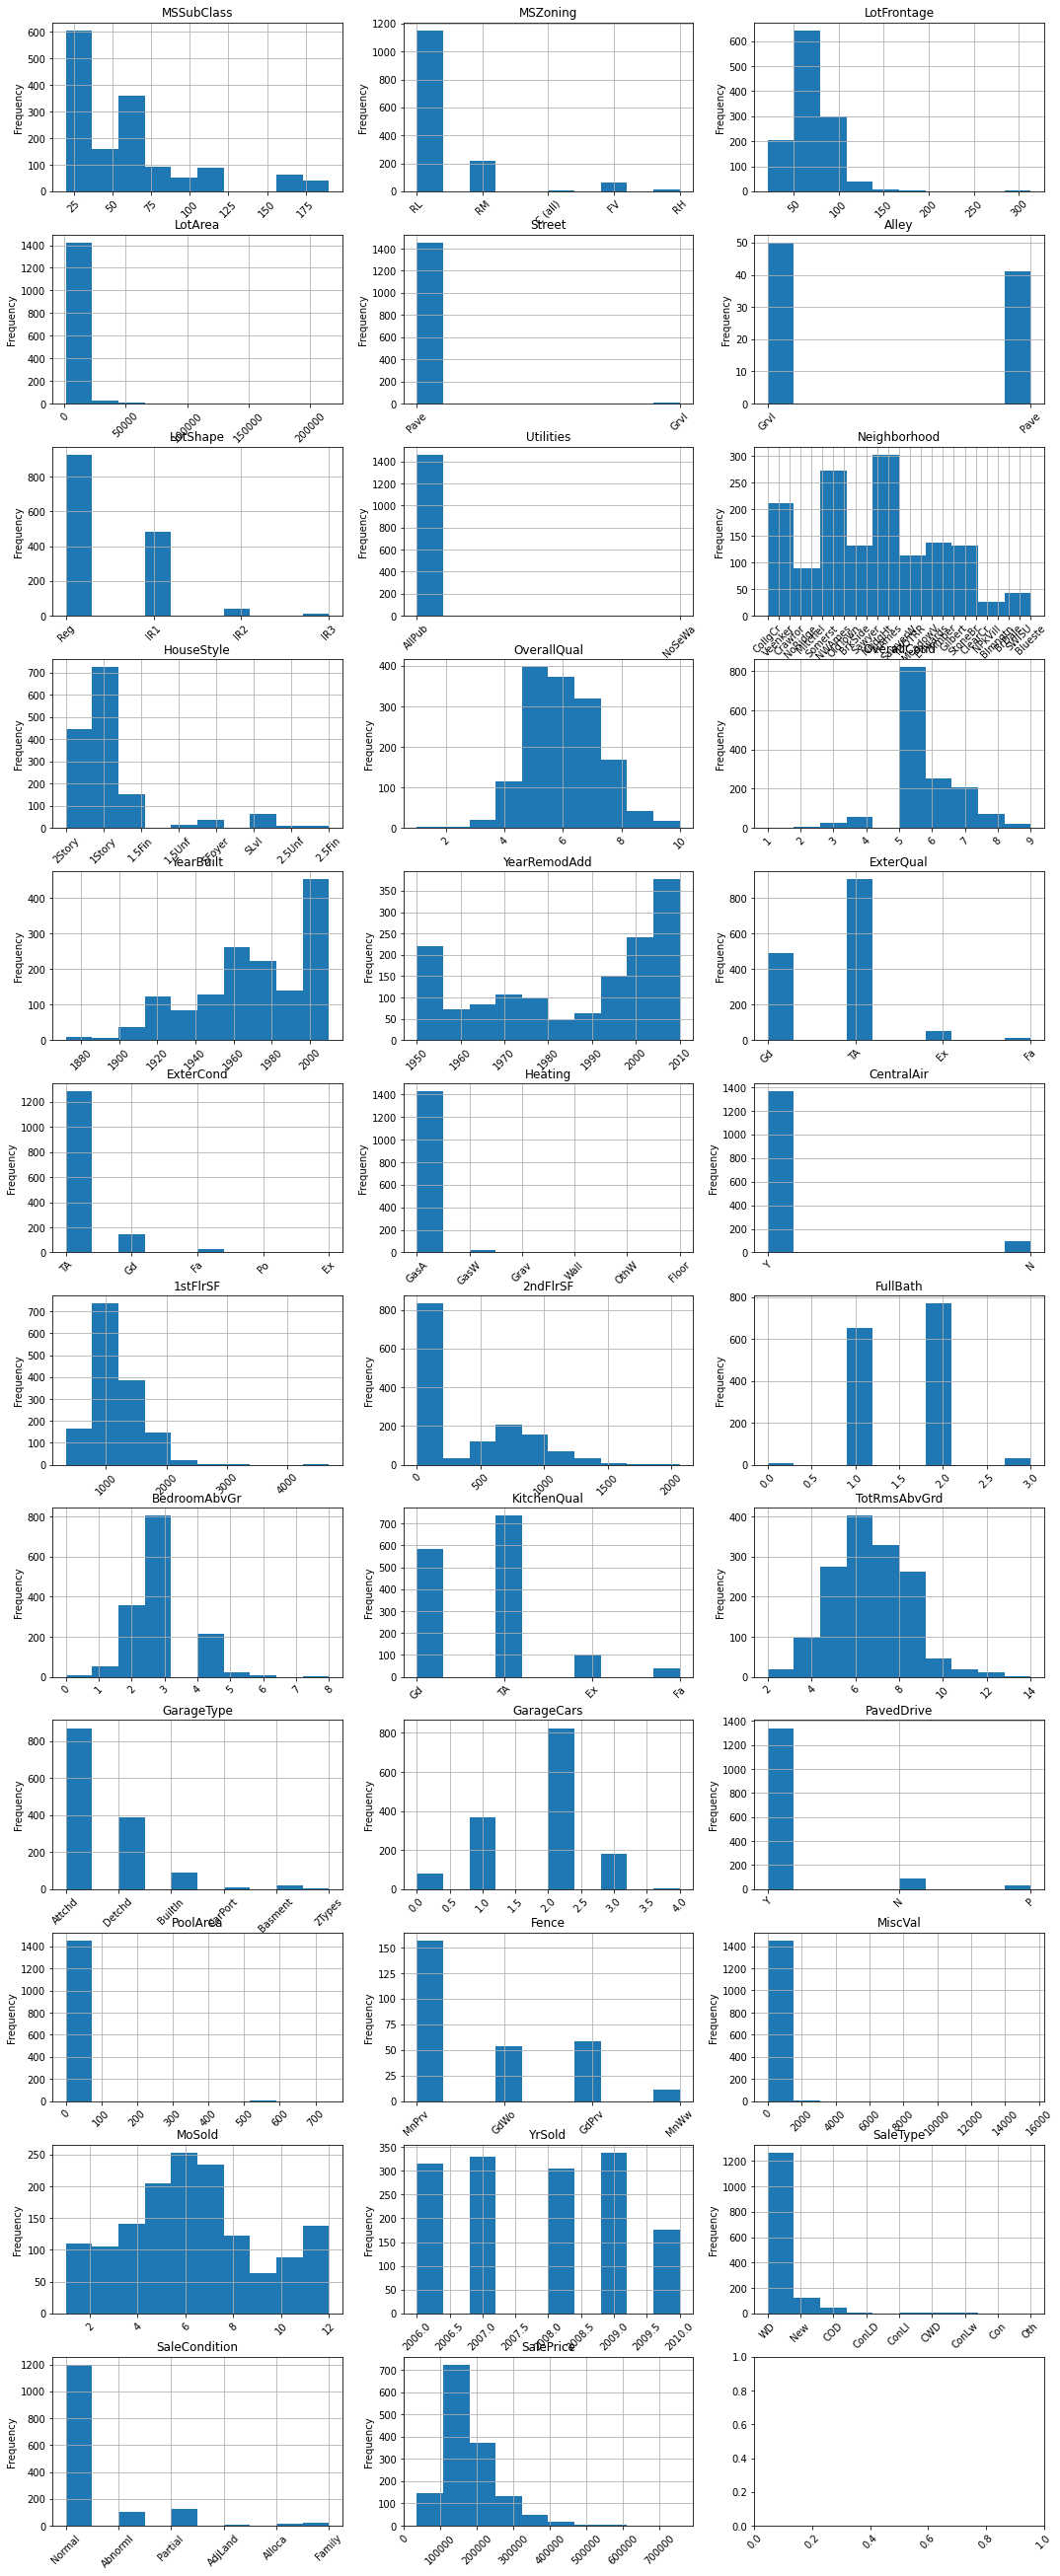

In [10]:
# Calculate the number of columns and rows for the subplots layout
n_cols = 3  # Set the number of columns as per your preference
n_rows = (len(data.columns) - 1) // n_cols + 1

# Create subplots with the specified layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3* n_rows))

# Flatten the 2D axes array to a 1D array for easier iteration
axes = axes.ravel()

# Loop through each feature and plot its histogram
for i, col in enumerate(data.columns):
    data[col].hist(ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")  # Remove x-axis label to avoid overlapping
    axes[i].set_ylabel("Frequency")

# Adjust layout and spacing
plt.tight_layout()

# Rotate x-axis labels to make them more legible
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Show the plot
plt.show()

# Data cleaning

### Removing Outliers

In [11]:
mask1 = data.LotArea < np.percentile(data.LotArea, 0.5)
mask2 = data.LotArea > np.percentile(data.LotArea, 99.5)

In [12]:
data = data.loc[~(mask1 | mask2) ,:]

### Handling missing values

In [13]:
data.loc[:, data.isna().any(axis= 0).values].isna().sum(axis= 0)

LotFrontage     255
Alley          1354
GarageType       78
Fence          1166
dtype: int64

In [14]:
data.drop(columns= ["Alley", "Fence"], inplace= True)

In [15]:
data.loc[:, data.isna().any(axis= 0).values].isna().sum(axis= 0)

LotFrontage    255
GarageType      78
dtype: int64

In [16]:
data.GarageType.value_counts()

Attchd     861
Detchd     386
BuiltIn     86
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [17]:
data.GarageType.mode().values[0]

'Attchd'

In [18]:
data.GarageType.fillna(data.GarageType.mode().values[0], inplace= True)

In [19]:
data.LotFrontage.fillna(data.LotFrontage.median(), inplace= True)

# Feature engeenering

In [20]:
data.insert((len(data.columns) - 1), "bedrooms_per_sqft", data.BedroomAbvGr / data.LotArea)

<AxesSubplot: >

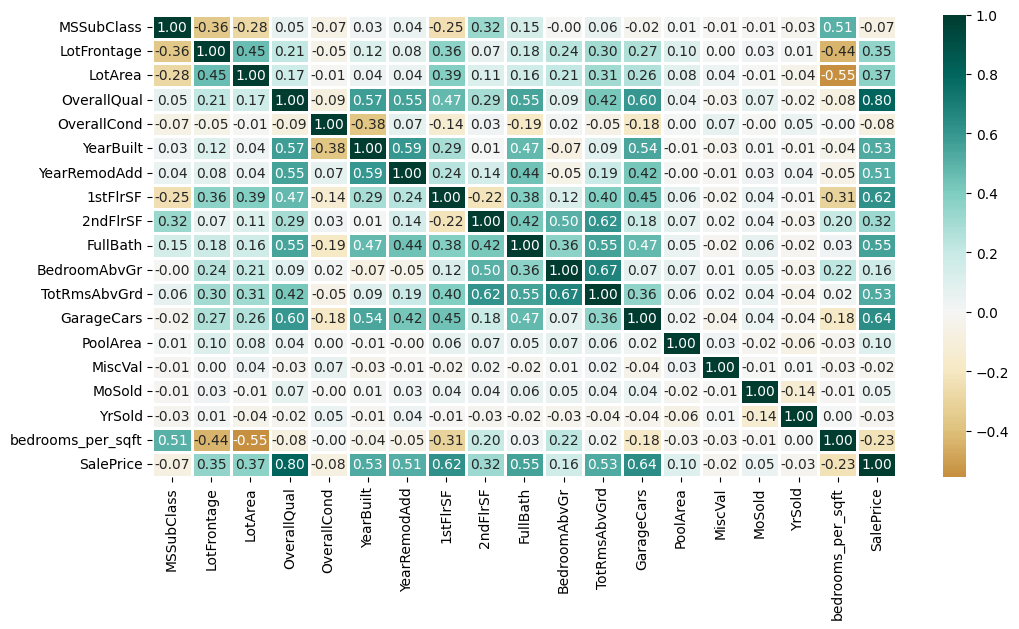

In [21]:
plt.rcdefaults()
plt.figure(figsize=(12, 6))
# df.iloc[:, :-1] bez ostatniej klumy
df_corr = data.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr,
            center = 0,
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True, 
            mask = None)

### Spliting data for feature importance, One-hot-Encoding

In [22]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_encoded = pd.get_dummies(X, drop_first= True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size= 0.2, random_state= 420)

In [23]:
from sklearn.feature_selection import mutual_info_regression

X_float_integer_only = X.select_dtypes(["float", "int"])
ig = mutual_info_regression(X_float_integer_only, y)

feature_scores = {}

for i in range(len(X_float_integer_only.columns)):
    feature_scores[X_float_integer_only.columns[i]] = ig[i]

feature_scores = dict(sorted(feature_scores.items(), key= lambda item: item[1], reverse= True))
feature_scores = {key: round(value, 3) for key, value in feature_scores.items()}

In [24]:
feature_scores

{'OverallQual': 0.572,
 'YearBuilt': 0.368,
 'GarageCars': 0.365,
 '1stFlrSF': 0.303,
 'MSSubClass': 0.273,
 'YearRemodAdd': 0.264,
 'FullBath': 0.251,
 'TotRmsAbvGrd': 0.216,
 '2ndFlrSF': 0.203,
 'LotFrontage': 0.183,
 'LotArea': 0.169,
 'OverallCond': 0.103,
 'bedrooms_per_sqft': 0.06,
 'BedroomAbvGr': 0.06,
 'YrSold': 0.003,
 'MiscVal': 0.002,
 'PoolArea': 0.0,
 'MoSold': 0.0}

In [25]:
data.drop(columns=['PoolArea', 'MiscVal', 'MoSold', 'YrSold'], inplace= True)

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
rf_model = RandomForestRegressor(random_state= 420)

# Train the model on the training data
rf_model.fit(X_encoded, y)

# Get the feature importances
feature_importances = rf_model.feature_importances_#.argsort()

# Match the importances with the corresponding feature names
feature_names = X_encoded.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Print the importance of each feature
#for feature, importance in feature_importance_dict.items():
#    print(f"{feature}: {importance}")

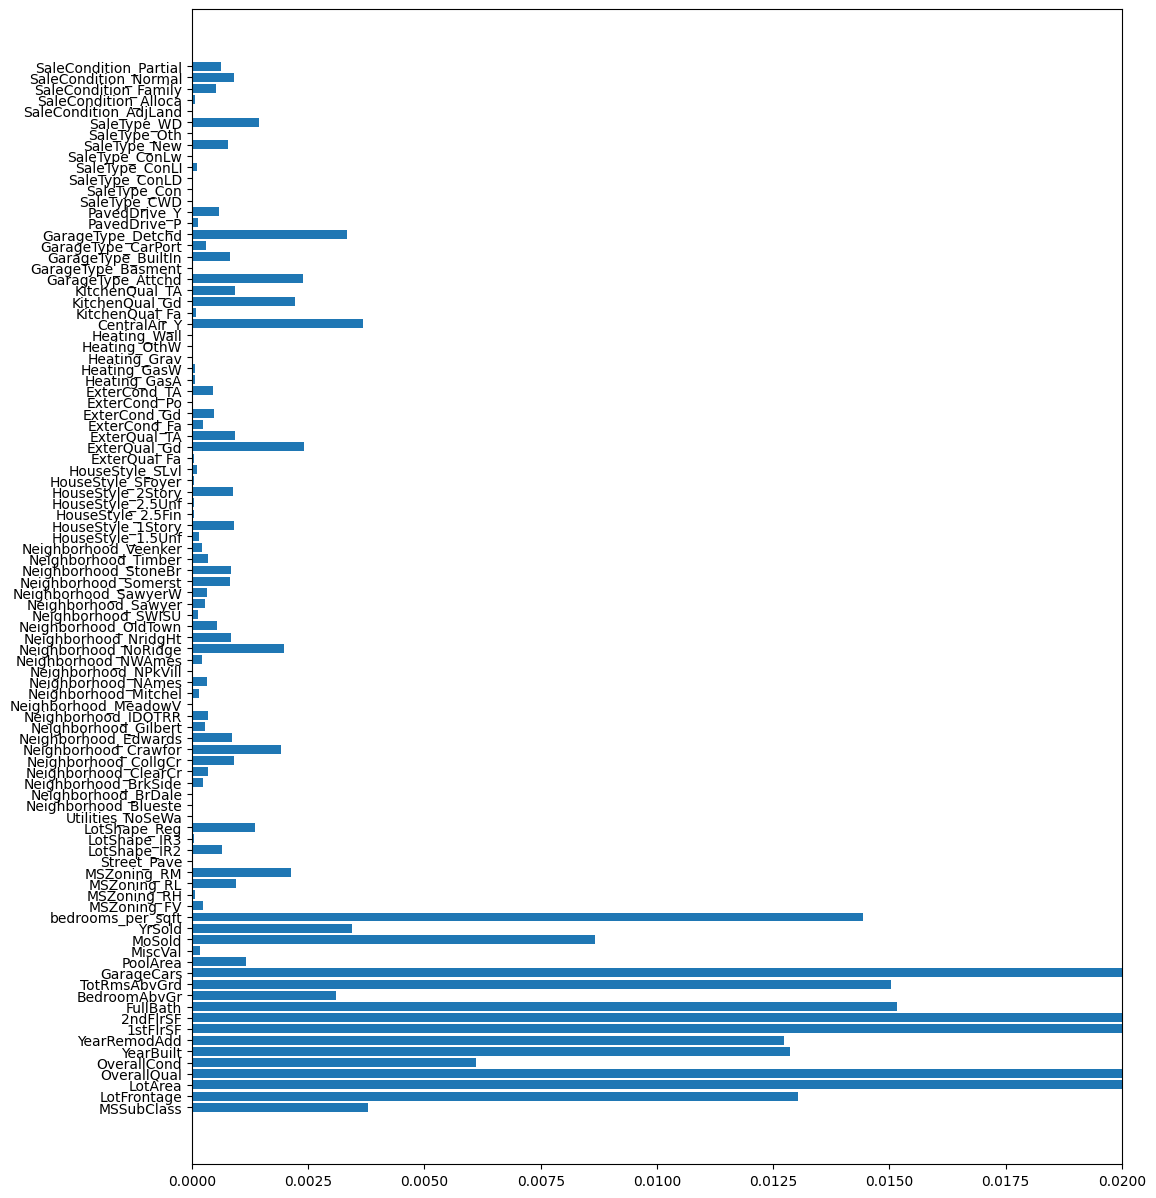

In [27]:
plt.figure(figsize=(12, 15))
plt.barh(y= list(feature_importance_dict.keys()), width= list(feature_importance_dict.values()))
plt.xlim(0, 0.02)
plt.show()

### All `Heating`, `Utilities`, `Street` categories has low importance

In [28]:
data.drop(columns= ["Heating", "Utilities", "Street"], inplace= True)

# Reducing Dimensionality

In [29]:
X_category = data.select_dtypes("object")

In [30]:
for column in X_category.columns:
    print(column, X_category[column].nunique())

MSZoning 5
LotShape 4
Neighborhood 25
HouseStyle 8
ExterQual 4
ExterCond 5
CentralAir 2
KitchenQual 4
GarageType 6
PavedDrive 3
SaleType 9
SaleCondition 6


In [31]:
feature_importance_dict_sorted = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

In [32]:
def select_n_most_important(column_name, n = 5):
    feature_name_list = []

    for feature, importance in feature_importance_dict_sorted.items():
        if column_name in feature:  
            feature_name_list.append(feature)

    feature_name_list = [item.split("_") for item in feature_name_list]
    feature_name_list = [i[1] for i in feature_name_list]
    feature_name_list = feature_name_list[0:n]
    return feature_name_list

In [33]:
def replace_least_important_features(column_name, n = 5):
    top_feauters = select_n_most_important(column_name, n)
    mask = data[column_name].isin(top_feauters)
    data.loc[~mask, column_name] = "Other"

In [34]:
X_category.columns

Index(['MSZoning', 'LotShape', 'Neighborhood', 'HouseStyle', 'ExterQual',
       'ExterCond', 'CentralAir', 'KitchenQual', 'GarageType', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

### Neighbors - top 5

In [35]:
for feature, importance in feature_importance_dict_sorted.items():
        if "Neighborhood" in feature:  
            print(feature, importance)

Neighborhood_NoRidge 0.001971139882418972
Neighborhood_Crawfor 0.0019053975734198984
Neighborhood_CollgCr 0.0009033184438318744
Neighborhood_Edwards 0.0008691855845883636
Neighborhood_StoneBr 0.0008411928161211623
Neighborhood_NridgHt 0.0008289127995920264
Neighborhood_Somerst 0.0008269407848847995
Neighborhood_OldTown 0.0005446055672125511
Neighborhood_IDOTRR 0.00035065503280834145
Neighborhood_Timber 0.00034671581656582563
Neighborhood_ClearCr 0.0003430274450311159
Neighborhood_NAmes 0.00031895187969782147
Neighborhood_SawyerW 0.0003143265275581699
Neighborhood_Sawyer 0.00028583225856238984
Neighborhood_Gilbert 0.0002703118059712193
Neighborhood_BrkSide 0.00023187348589359276
Neighborhood_Veenker 0.00021981911251377247
Neighborhood_NWAmes 0.00021924220915681337
Neighborhood_Mitchel 0.0001583477608521459
Neighborhood_SWISU 0.00012424926740884173
Neighborhood_MeadowV 2.427138069894878e-05
Neighborhood_BrDale 6.214357125284343e-06
Neighborhood_NPkVill 4.863180774336036e-06
Neighborhood_

In [36]:
select_n_most_important("Neighborhood" , 5)

['NoRidge', 'Crawfor', 'CollgCr', 'Edwards', 'StoneBr']

In [37]:
#replace_least_important_features("Neighborhood" , 5)

In [38]:
data.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards     99
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
IDOTRR      37
Timber      35
ClearCr     25
SWISU       25
StoneBr     24
Blmngtn     17
BrDale      16
Veenker     11
MeadowV     11
NPkVill      9
Blueste      1
Name: Neighborhood, dtype: int64

###  Sale Condition

In [39]:
replace_least_important_features("SaleCondition" , 3)

### SaleType

In [40]:
replace_least_important_features("SaleType" , 2)

### ExterCond

In [41]:
replace_least_important_features("ExterCond" , 2)

In [42]:
data.ExterCond.value_counts()

TA       1268
Gd        145
Other      32
Name: ExterCond, dtype: int64

### Exter Qual

In [43]:
replace_least_important_features("ExterQual" , 2)

In [44]:
data.ExterQual.value_counts()

TA       894
Gd       487
Other     64
Name: ExterQual, dtype: int64

### HouseStyle

In [45]:
replace_least_important_features("HouseStyle" , 2)

### GarageType

In [46]:
replace_least_important_features("GarageType" , 3)

### Kitchen Quality

In [47]:
replace_least_important_features("KitchenQual" , 2)

In [48]:
data.KitchenQual.value_counts()

TA       727
Gd       582
Other    136
Name: KitchenQual, dtype: int64

## MSZoning

In [49]:
replace_least_important_features("MSZoning" , 2)

In [50]:
data.MSZoning.value_counts()

RL       1143
RM        211
Other      91
Name: MSZoning, dtype: int64

In [51]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_encoded = pd.get_dummies(X)


rf_model = RandomForestRegressor(random_state= 420)
rf_model.fit(X_encoded, y)

feature_importances = rf_model.feature_importances_

feature_names = X_encoded.columns  # Assuming you have a pandas DataFrame with column names
feature_importance_dict = dict(zip(feature_names, feature_importances))


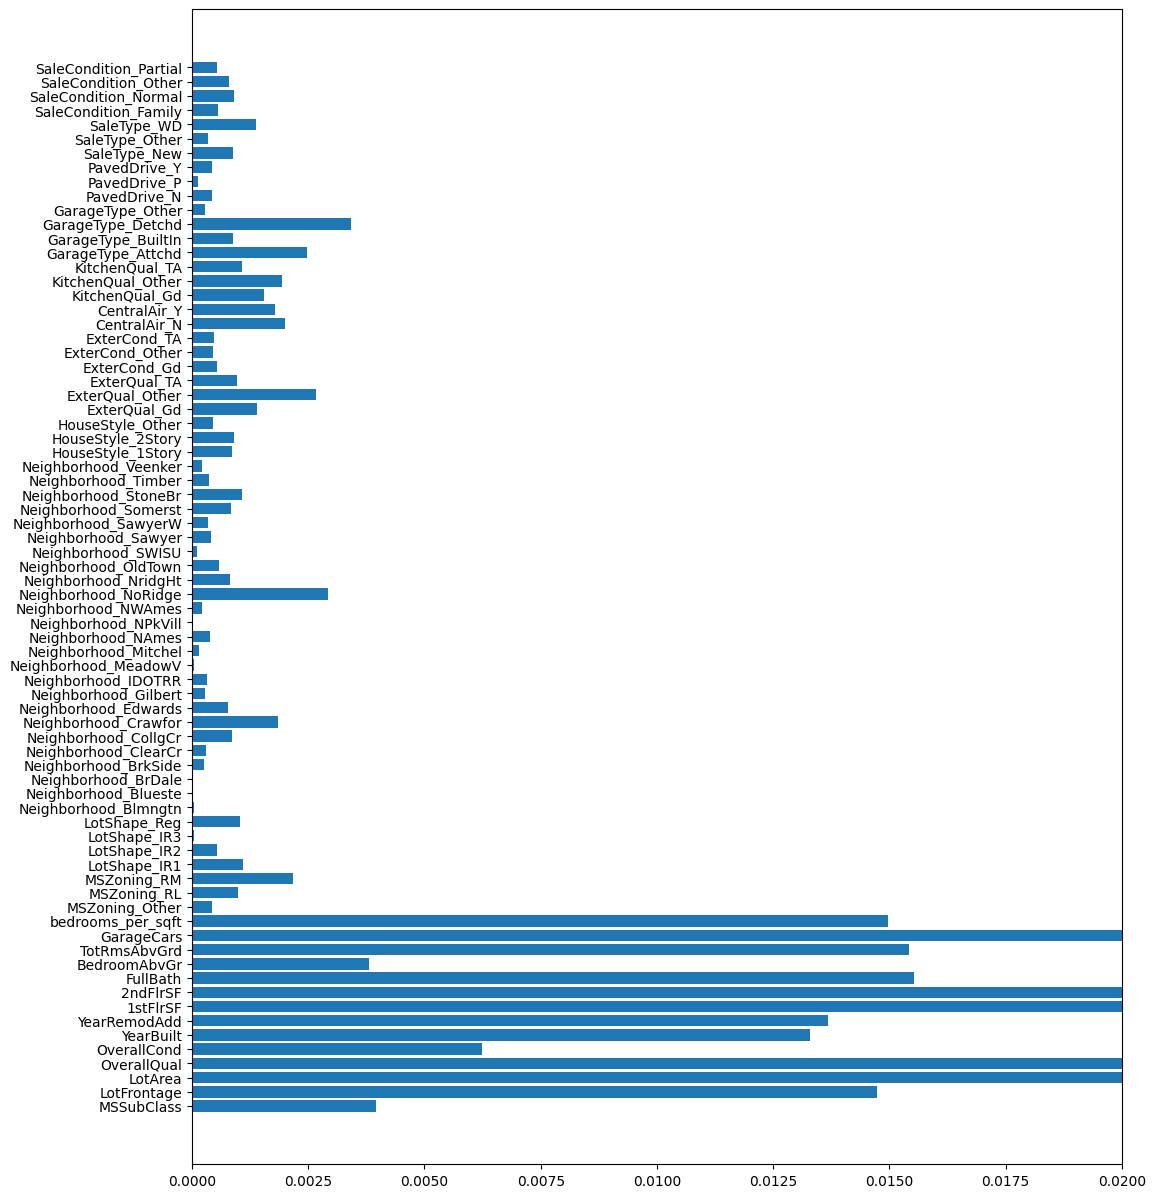

In [52]:

plt.figure(figsize=(12, 15))
plt.barh(y= list(feature_importance_dict.keys()), width= list(feature_importance_dict.values()))
plt.xlim(0, 0.02)
plt.show()

# Models

_______________________________________________________________________________


In [53]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_encoded = pd.get_dummies(X, drop_first= True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size= 0.2, random_state= 420)

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
rf_model = RandomForestRegressor(random_state= 420)

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=420)

In [55]:
from sklearn.metrics import r2_score

y_pred = rf_model.predict(X_test)
r2_score(y_pred, y_test)

0.8297553393847135

In [56]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with R2 scoring metric
cv_scores = cross_val_score(rf_model, X_test, y_test, cv=5, scoring='r2')

# Print the R2 scores for each fold
print("R2 Scores for each fold:", cv_scores)

# Calculate the average R2 score across all folds
average_r2_score = cv_scores.mean()
print("Average R2 Score:", average_r2_score)

R2 Scores for each fold: [0.86352259 0.75628978 0.870129   0.8648477  0.77385929]
Average R2 Score: 0.825729671612806


### Tunning hyperparameters

In [57]:
from sklearn.model_selection import GridSearchCV


In [58]:
param_grid = {
    "n_estimators": [650, 700, 750],
    "max_depth": [32]
    }

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring = "r2", return_train_score = False)

grid_search.fit(X_train, y_train)

print("grid_search.best_score_:", grid_search.best_score_, "\n",
      "grid_search.best_params_:", grid_search.best_params_)

grid_search.best_score_: 0.8385922658850848 
 grid_search.best_params_: {'max_depth': 32, 'n_estimators': 700}


In [59]:
rf_model = RandomForestRegressor(max_depth= 32, n_estimators= 700, random_state= 420)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
r2_score(y_pred, y_test)

0.8373423362586982

# XGBoost

In [60]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor()
XGB_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [61]:
y_pred = XGB_model.predict(X_test)
r2_score(y_pred, y_test)

0.8579237011215458

### Tunning hyperparameters

In [62]:
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [4, 8, 16]
    }

grid_search = GridSearchCV(XGB_model, param_grid, cv=5, scoring = "r2", return_train_score = False)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [4, 8, 16],
                         'n_estimators': [200, 400, 600]},
             scoring='r2')

In [63]:
print("grid_search.best_score_:", grid_search.best_score_, "\n"
      "grid_search.best_params_:", grid_search.best_params_)

grid_search.best_score_: 0.8090975755442406 
grid_search.best_params_: {'max_depth': 4, 'n_estimators': 200}


In [64]:
XGB_model = XGBRegressor(max_depth= 8, n_estimators= 200)
XGB_model.fit(X_train, y_train)

y_pred = XGB_model.predict(X_test)
r2_score(y_pred, y_test)

0.8295238692757189

In [65]:
# Perform cross-validation with R2 scoring metric
cv_scores = cross_val_score(XGB_model, X_test, y_test, cv=5, scoring='r2')

# Print the R2 scores for each fold
print("R2 Scores for each fold:", cv_scores)

# Calculate the average R2 score across all folds
average_r2_score = cv_scores.mean()
print("Average R2 Score:", average_r2_score)

R2 Scores for each fold: [0.84313454 0.8082009  0.77072409 0.83921067 0.64914555]
Average R2 Score: 0.782083149054732
